cuda:0


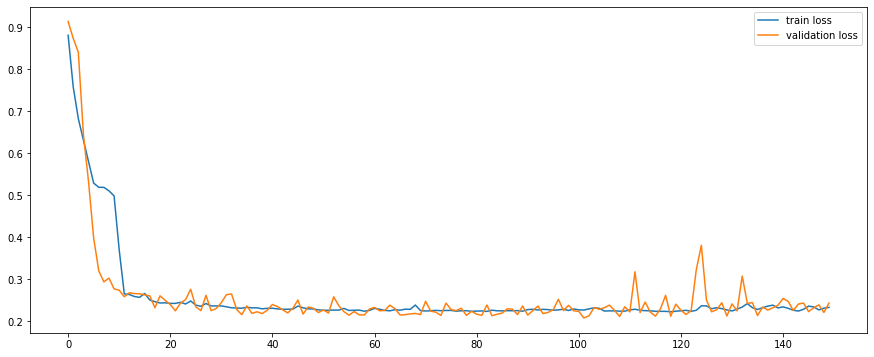

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import math
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from vit import VisionTransformer as ViT
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
train_losses = np.loadtxt('train_losses_vit0.01_10.txt')
test_losses = np.loadtxt('test_losses_vit0.01_k10.txt')
# train_losses = np.loadtxt('train_losses_vit0.01_10_p2.txt')
# test_losses = np.loadtxt('test_losses_vit0.01_k10_p2.txt')
plt.figure(figsize=(15,6))
a =300
plt.plot(train_losses[:a], label='train loss')
plt.plot(test_losses[:a], label='validation loss')
plt.legend()

In [2]:
test_losses[:a].min()
# train_losses[404]

0.2072024423089435

In [3]:
def load_loss():
    train_losses = np.loadtxt('train_losses_vit0.01_10.txt')
    test_losses = np.loadtxt('test_losses_vit0.01_k10.txt')
    min_idx = np.argmin(test_losses)
    print(min_idx)
    train_losses = train_losses[:min_idx+1]
    test_losses = test_losses[:min_idx+1]
    min_idx = np.argmin(test_losses)
    print(min_idx)
    print(train_losses.shape, test_losses.shape)
    return train_losses, test_losses

load_loss()

101
101
(102,) (102,)


(array([0.88120391, 0.7580067 , 0.68246766, 0.63129574, 0.58113658,
        0.52874283, 0.51875425, 0.518646  , 0.5103451 , 0.49822115,
        0.36990766, 0.2646665 , 0.26307085, 0.25831414, 0.25641604,
        0.26558037, 0.24991054, 0.2460504 , 0.24290605, 0.24337214,
        0.24194975, 0.24197996, 0.24458707, 0.24054553, 0.24772414,
        0.23782842, 0.23509592, 0.24171245, 0.23592634, 0.23597252,
        0.23594042, 0.23391778, 0.23145975, 0.23082547, 0.23045056,
        0.23260829, 0.231385  , 0.23133732, 0.22905892, 0.23020817,
        0.23043887, 0.22881427, 0.22790887, 0.22805603, 0.22829222,
        0.23556735, 0.23152858, 0.22898488, 0.22869149, 0.22645689,
        0.22568474, 0.22551394, 0.22613797, 0.22590146, 0.2300896 ,
        0.2251402 , 0.22546895, 0.22601033, 0.22327777, 0.22526302,
        0.23005733, 0.22804662, 0.22528676, 0.22427819, 0.22693225,
        0.22578052, 0.22816974, 0.22779465, 0.23806451, 0.22479885,
        0.22388693, 0.2243956 , 0.22530987, 0.22

In [4]:

def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N] - 1

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y

class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k]
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)
#         self.x = torch.from_numpy(x)
#         self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]
    

root_train = '/tf/data/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training'
root_test = '/tf/data/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing'
train_data_path = root_train + '/Train_Dst_NoAuction_ZScore_CF_7.txt'
test_data_path1 = root_test + '/Test_Dst_NoAuction_ZScore_CF_7.txt'
test_data_path2 = root_test + '/Test_Dst_NoAuction_ZScore_CF_8.txt'
test_data_path3 = root_test + '/Test_Dst_NoAuction_ZScore_CF_9.txt'

dec_data = np.loadtxt(train_data_path)
dec_test1 = np.loadtxt(test_data_path1)
dec_test2 = np.loadtxt(test_data_path2)
dec_test3 = np.loadtxt(test_data_path3)

dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

batch_size = 32

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

(149, 203800) (149, 50950) (149, 139587)
torch.Size([203701, 1, 100, 40]) torch.Size([203701])


In [5]:
# model = ViT(
#         in_channels=1,
#         embedding_dim=32,
#         num_layers=2,
#         num_heads=4,
#         qkv_bias=False,
#         mlp_ratio=4.0,
#         dropout_rate=0.0,
#         num_classes= 3,
#     ).cuda(device)
# model.load_state_dict(torch.load('model_save/FI2010/FE/100/k_10/ocet/ocet_epoch_96_valloss_0.4536_valacc_0.8352.pth')) #torch.load('best_val_model_pytorch')
model = torch.load('best_val_model_pytorch')
print(model)


OCET(
  (oce): Sequential(
    (0): ZeroPad2d(padding=(0, 0, 1, 2), value=0.0)
    (1): Conv2d(1, 1, kernel_size=(4, 1), stride=(1, 1))
    (2): Sigmoid()
  )
  (conv1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(2, 4, kernel_size=(1, 2), stride=(1, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(4, 40, kernel_size=(1, 10), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qk

In [6]:
# import numpy as np
# import torch
# import torch.nn as nn
# from torch import optim
# from torch.utils.data import DataLoader
# import os
# import time
# from tqdm import tqdm
# import sys
# from data_precess.data import LOBDataset
# import logging
# # from vit import VisionTransformer as ViT
# k = 0
# dep = 1

# # dataset_train = LOBDataset(k, T=100, split='train')
# # dataloader_train = DataLoader(dataset=dataset_train, batch_size=256, shuffle=True)
# dataset_test = LOBDataset(k, T=100, split='test')

# dataloader_test = DataLoader(dataset=dataset_test, batch_size=256, shuffle=False)
# start_time = time.time()
# loss_fn = nn.CrossEntropyLoss(reduction='mean')
# model.eval()
# correct = 0.0
# total = 0.0
# test_acc = []
# best_acc = 0.0
# best_epoch = 1
# best_loss = 2.0
# test_loss = []
# loss_epoch = []
# all_targets = []
# all_predictions = []
# for (lob, label) in tqdm(dataloader_test, ncols=40):
#     lob, label = lob.cuda(), label.cuda()
#     outputs = model(lob)
#     _, predicted = torch.max(outputs.data, 1)
#     total += label.size(0)
#     correct += float(torch.sum(predicted == label))
#     all_targets.append(label.cpu().numpy())
#     all_predictions.append(predicted.cpu().numpy())

#     loss = loss_fn(outputs, label)
#     loss_epoch.append(loss.item())


# end_time = time.time()
# curr_acc = correct / total
# # logging.info('Evaluating Network.....')
# # logging.info('Test set: Epoch: {}, Current Accuracy: {:.4f}, Time consumed:{:.2f}s'.format(
# #     epoch,
# #     curr_acc,
# #     end_time - start_time
# # ))
# test_loss.append(np.mean(loss_epoch))
# curr_loss = test_loss[-1]

# print(f"Test acc: {curr_acc:.4f}")
# all_targets = np.concatenate(all_targets)    
# all_predictions = np.concatenate(all_predictions)
# print('accuracy_score:', accuracy_score(all_targets, all_predictions))
# print(classification_report(all_targets, all_predictions, digits=4))


In [7]:
# model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = F.softmax(model(inputs), dim=1)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking argument for argument weight in method wrapper__cudnn_convolution)

In [ ]:
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = F.softmax(model(inputs), dim=1)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)

In [ ]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))


In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score

def accuracy_score(y, y_pred, average=None):
    """
    Calculate accuracy as a percentage.
    Input:
        y - tensor of true labels,
        y_pred - tensor of predicted labels,
        average - dummy variable for consistency
    Return:
        accuracy score in percents
    """
    return (y_pred == y).float().mean().item() * 100

def calculate_f1(y, y_pred, average='weighted'):
    """
    Calculate f1 score as a percentage.
    Input:
        y - tensor of true labels,
        y_pred - tensor of predicted labels,
        average - averaging method
    Return:
        f1 score in percents
    """
    return f1_score(y.detach().cpu(), y_pred.detach().cpu(), average=average) * 100

def calculate_precision(y, y_pred, average='weighted'):
    """
    Calculate precision as a percentage.
    Input:
        y - tensor of true labels,
        y_pred - tensor of predicted labels,
        average - averaging method
    Return:
        precision score in percents
    """
    return precision_score(y.detach().cpu(), y_pred.detach().cpu(), average=average) * 100

def calculate_recall(y, y_pred, average='weighted'):
    """
    Calculate recall as a percentage.
    Input:
        y - tensor of true labels,
        y_pred - tensor of predicted labels,
        average - averaging method
    Return:
        recall score in percents
    """
    return recall_score(y.detach().cpu(), y_pred.detach().cpu(), average=average) * 100
def infer_model(model, test_loader, device):
    model.eval()

    f1, acc, prec, rec = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for (X, y) in test_loader:
            X, y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)

            y_pred_raw = model(X)
            y_pred = y_pred_raw.softmax(dim=1).argmax(dim=1)

            f1  += calculate_f1(y, y_pred, average='weighted')
            acc += accuracy_score(y, y_pred)
            prec += calculate_precision(y, y_pred, average='weighted')
            rec += calculate_recall(y, y_pred, average='weighted')
    return acc / len(test_loader), f1 / len(test_loader), prec / len(test_loader), rec / len(test_loader)

In [34]:
test_acc, test_f1, test_prec, test_rec = infer_model(model, test_loader, device)
print("XRP transfer learning:")
print("Test accuracy: {} %".format(test_acc))
print("Test F1 score: {} %".format(test_f1))
print("Test precision score: {} %".format(test_prec))
print("Test recall score: {} %".format(test_rec))

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'